In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
acm = pd.read_excel('merged_data/acm_recordlinkage_post.xlsx')

# Feature Construction

### Rating Difference

In [3]:
# Difference: Difference in scores between source pairs: ani_crunch, ani_mal, and crunch_mal
acm['ani_crunch_diff'] = acm['rating_aw'] - acm['rating_cr']
acm['mal_ani_diff'] = acm['rating_mal'] - acm['rating_aw']
acm['mal_crunch_diff'] = acm['rating_mal'] - acm['rating_cr']

# Calculate the squared difference (error for the mal differences)
print(sum(acm['mal_ani_diff'] * acm['mal_ani_diff']))
print(sum(acm['mal_crunch_diff'] * acm['mal_crunch_diff']))
print(sum(acm['ani_crunch_diff'] * acm['ani_crunch_diff']))
#Interesting: aniwave and crunchyrole both seem pretty different from mal (mal ratings a lot lower) but are a lot more similar to each other.


1659.192299999999
1654.0137
834.0897999999997


### Show Age

In [4]:
# Convert string dates to datetime
acm['start_date'] = pd.to_datetime(acm['start_date'])

# Define the reference date
reference_date = pd.to_datetime('2024-01-01')

# Calculate the difference in days
acm['show_age'] = (reference_date - acm['start_date']).dt.days

### Controversy

In [5]:
# This is how much aniwave and crunchyroll disagree in score for each show
acm['controversy'] = (acm['rating_aw'] - acm['rating_cr']) ** 2

### Weighted Score

In [6]:
def normalize(scores:pd.Series) -> pd.Series:
    min = scores.min()
    max = scores.max()
    base = max - min
    normalized = (scores - min) / base
    return normalized

def get_weighted_score(ratings:pd.Series, votes:pd.Series) -> pd.Series: #just return a series
    rating_normalized = normalize(ratings)
    votes_normalized = normalize(votes)
    weighted_score = (rating_normalized * 0.2) + (votes_normalized * 0.8) # More concerned with commercial success: Popularity most important
    return weighted_score

acm['weighted_score_aw'] = get_weighted_score(acm['rating_aw'], acm['votes_aw'])
acm['weighted_score_cr'] = get_weighted_score(acm['rating_cr'], acm['votes_cr'])
acm['weighted_score_mal'] = get_weighted_score(acm['rating_mal'], acm['members'])

display(acm[['anime','weighted_score_aw', 'weighted_score_cr', 'weighted_score_mal']].sort_values(by='weighted_score_mal', ascending=False))

,anime,weighted_score_aw,weighted_score_cr,weighted_score_mal
138,Death Note,0.368952,0.189212,0.979065
53,Attack on Titan,0.421864,0.222408,0.955489
183,Fullmetal Alchemist:Brotherhood,0.289024,0.202460,0.894605
402,One Punch Man,0.294839,0.170894,0.832930
497,Sword Art Online,0.278997,0.233018,0.811557
...,...,...,...,...
333,makuranodanshi,0.123082,0.132573,0.035486
518,The Glass Mask Year 3 Class D,0.057816,0.160033,0.032983
310,Love Rice,0.129885,0.138614,0.032682
522,The Irresponsible Galaxy☆Tylor,0.003144,0.057897,0.007775


### Source Dummy Variables

In [7]:
# Use the get_dummies function to perform one-hot encoding
df_encoded = pd.get_dummies(acm['source'], prefix='Category')

# Concatenate the original DataFrame and the one-hot encoded DataFrame
acm = pd.concat([acm, df_encoded], axis=1)

In [8]:
acm.to_excel('merged_data/acm.xlsx')

# EDA

In [7]:
acm = pd.read_excel('merged_data/acm.xlsx', index_col=False)

In [8]:
x_vars_aw = ['weighted_score_cr', 'weighted_score_mal', 'show_age', 'controversy', 'episodes'] #would I have problems with colinearity if I includd rating/pop from cr and mal?
x_vars_cr = ['weighted_score_aw', 'weighted_score_mal', 'show_age', 'controversy', 'episodes']
x_vars_mal = ['weighted_score_aw', 'weighted_score_cr', 'show_age', 'controversy', 'episodes']

In [9]:
from scipy import stats

#remove outliers 
def remove_outliers(col: pd.Series) -> pd.Series:
    threshold = 3
    col = col[stats.zscore(col) < threshold]
    return col

acm_noOutliers = acm.copy()
acm_noOutliers['show_age'] = remove_outliers(acm_noOutliers['show_age'])
acm_noOutliers['controversy'] = remove_outliers(acm_noOutliers['controversy'])
acm_noOutliers['episodes'] = remove_outliers(acm_noOutliers['episodes'])

Text(0.5, 1.08, 'Pairplot - MyAnimeList')

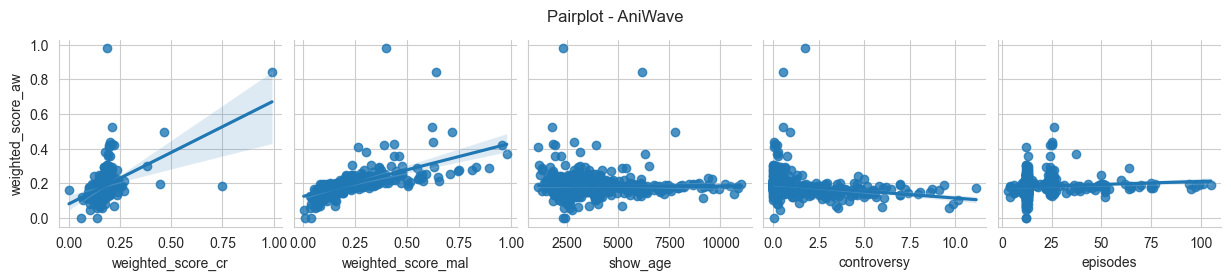

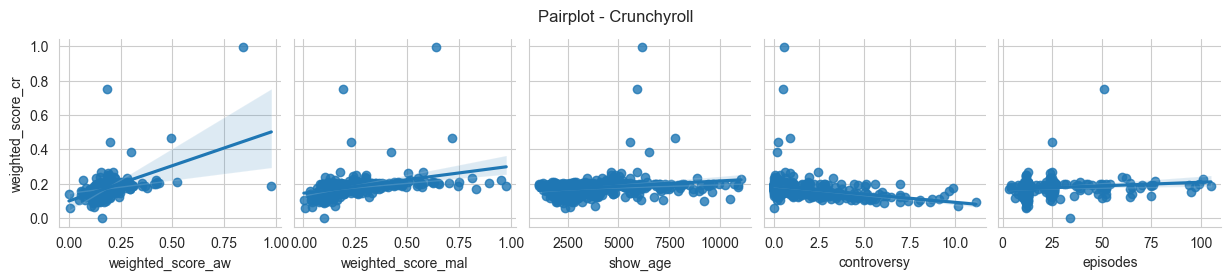

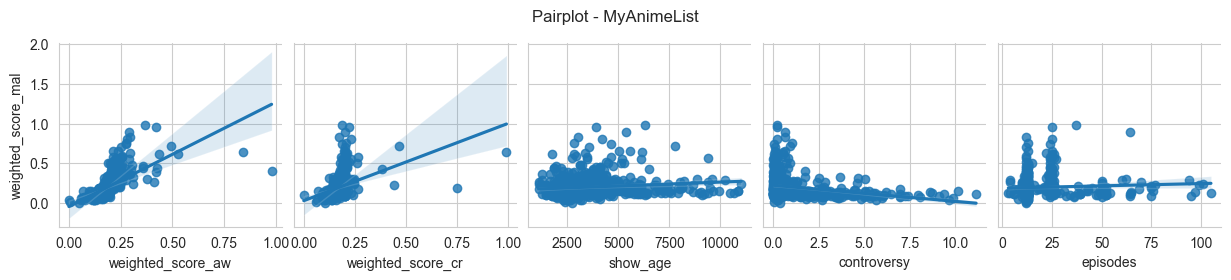

In [10]:
sns.set_style('whitegrid')
pairplot_aw = sns.pairplot(data=acm_noOutliers, x_vars=x_vars_aw, y_vars='weighted_score_aw', kind='reg')
pairplot_aw.figure.suptitle("Pairplot - AniWave", y=1.08)

pairplot_cr = sns.pairplot(data=acm_noOutliers, x_vars=x_vars_cr, y_vars='weighted_score_cr', kind='reg')
pairplot_cr.figure.suptitle("Pairplot - Crunchyroll", y=1.08)

pairplot_mal = sns.pairplot(data=acm_noOutliers, x_vars=x_vars_mal, y_vars='weighted_score_mal', kind='reg')
pairplot_mal.figure.suptitle("Pairplot - MyAnimeList", y=1.08)

In [11]:
aniwave = pd.read_csv('raw_data/aniwave_final.csv')
crunchyroll = pd.read_csv('raw_data/crunchyroll.csv')
myanimelist = pd.read_csv('raw_data/mal.csv')

### Number of Shows by Site

,site,observations


,site,observations
0,AniWave,11675
0,Crunchyroll,1255
0,MyAnimeList,17562


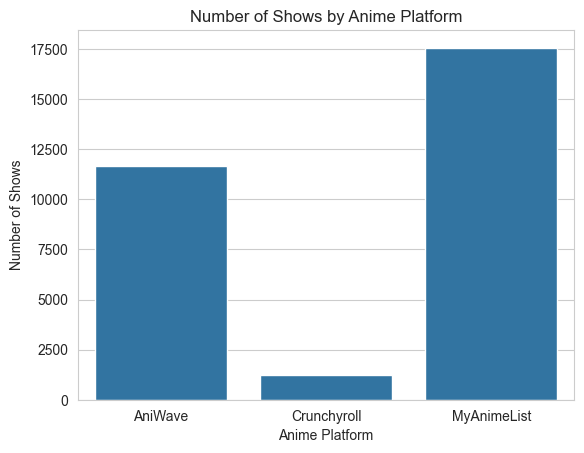

In [12]:
sites = [aniwave, crunchyroll, myanimelist]
site_names = ['AniWave', 'Crunchyroll', 'MyAnimeList']

shows_per_site = pd.DataFrame(columns=['site', 'observations'])
display(shows_per_site)

for site, name in zip(sites, site_names):
    observations = len(site)
    temp_df = pd.DataFrame({'site':[name], 'observations':[observations]})
    shows_per_site = pd.concat([shows_per_site, temp_df])

display(shows_per_site)

g = sns.barplot(data=shows_per_site, x='site', y='observations')
g.set(title='Number of Shows by Anime Platform')
g.set_xlabel('Anime Platform')
g.set_ylabel('Number of Shows')

# Save the figure
plt.savefig('graphs/Number of Shows by Anime Platform.png')  # You can change the file extension to other formats like .jpg, .pdf, etc.

# Show the plot
plt.show()

### Average Ratings By Site

/var/folders/6t/m8p7kvf97cd38j154jl_hcx00000gn/T/ipykernel_46345/3150126290.py:9: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  average_score_per_site = pd.concat([average_score_per_site, temp_df])


,site,average_rating
0,AniWave,8.574286
0,Crunchyroll,8.431653
0,MyAnimeList,7.099856


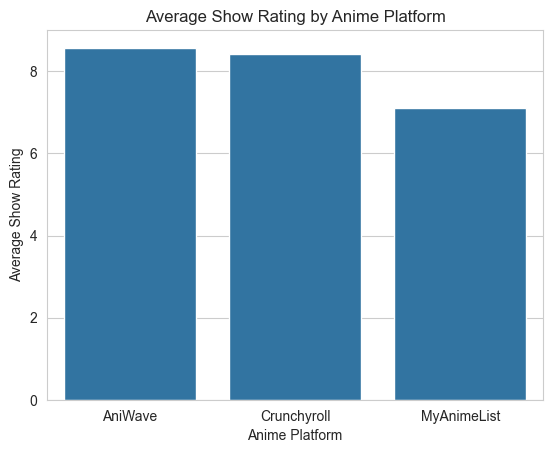

In [12]:
site_ratings = ['rating_aw', 'rating_cr', 'rating_mal']
names = ['AniWave', 'Crunchyroll', 'MyAnimeList']

average_score_per_site = pd.DataFrame(columns=['site', 'average_rating'])

for site_rating, name in zip(site_ratings, names):
    average_rating = acm[site_rating].mean()
    temp_df = pd.DataFrame({'site':[name], 'average_rating':[average_rating]})
    average_score_per_site = pd.concat([average_score_per_site, temp_df])

display(average_score_per_site)


g = sns.barplot(data=average_score_per_site, x='site', y='average_rating')
g.set(title='Average Show Rating by Anime Platform')
g.set_xlabel('Anime Platform')
g.set_ylabel('Average Show Rating')

# Save the figure
plt.savefig('graphs/Average Show Rating by Anime Platform.png')  # You can change the file extension to other formats like .jpg, .pdf, etc.

# Show the plot
plt.show()


### Most Popular Shows by Site

In [13]:
aniwave_popular = aniwave.nlargest(20, 'Vote Count')[['Title', 'Rating']]
aniwave_popular.reset_index(drop=True, inplace=True)

crunchyroll_popular = crunchyroll.nlargest(20, 'votes')[['anime', 'rate']]
crunchyroll_popular['rate'] = crunchyroll_popular['rate'] * 2
crunchyroll_popular.reset_index(drop=True, inplace=True)

myanimelist_popular = myanimelist[myanimelist['Popularity'] >= 1] #some popularity = 0 shows?
myanimelist_popular = myanimelist_popular.nsmallest(20, 'Popularity')[['Name', 'Score']]
myanimelist_popular.reset_index(drop=True, inplace=True)

popular_shows = pd.DataFrame({'AniWave':aniwave_popular['Title'], 'Crunchyroll':crunchyroll_popular['anime'], 'MyAnimeList':myanimelist_popular['Name']})
display(popular_shows)

popular_shows.to_excel('data_tables/popular_shows.xlsx')

,AniWave,Crunchyroll,MyAnimeList
0,ONE PIECE,Naruto Shippuuden,Death Note
1,Redo of Healer,Shugo Chara,Shingeki no Kyojin
2,The Eminence in Shadow,BLEACH,Fullmetal Alchemist: Brotherhood
3,Black Clover,Naruto,Sword Art Online
4,JUJUTSU KAISEN,Skip Beat!,One Punch Man
5,Naruto: Shippuden,REBORN!,Boku no Hero Academia
6,Boruto: Naruto Next Generations,Gintama,Tokyo Ghoul
7,JUJUTSU KAISEN Season 2,La Corda d'Oro ~primo passo~ and ~secondo passo~,Naruto
8,Attack on Titan Final Season,Eyeshield 21,Steins;Gate
9,Chainsaw Man,Hayate the Combat Butler! (S1 e S2),No Game No Life


In [14]:
#aniwave
aniwave_dates = pd.to_datetime(aniwave.nlargest(20, 'Vote Count')['Start Date']).dt.year
aniwave_age = 2024 - aniwave_dates # collection: 2024
aniwave_age = aniwave_age.reset_index(drop=True)


#myanimelist
def start_date(aired):
    return aired.partition(' t')[0]
# Get just the start date for myanimelist
myanimelist_dates = myanimelist[myanimelist['Aired'] != 'Unknown']
myanimelist_dates['Aired'] = myanimelist_dates['Aired'].apply(start_date)
myanimelist_dates = myanimelist_dates[myanimelist_dates['Popularity'] >= 1] #some popularity = 0 shows?

myanimelist_dates = pd.to_datetime((myanimelist_dates.nsmallest(20, 'Popularity')['Aired']), format='mixed').dt.year
myanimelist_age = 2021 - myanimelist_dates
myanimelist_age = myanimelist_age.reset_index(drop=True)


#crunchyroll
crunchyroll_dates = [2007, 2007, 2004, 2002, 2008, 2006, 2011, 2006, 2005, 2007, 2008, 2007, 2011, 2010, 2008, 2009, 2007, 2012, 2010, 2010]
crunchyroll_dates = pd.Series(crunchyroll_dates)
crunchyroll_age = 2019 - crunchyroll_dates
crunchyroll_age = crunchyroll_age.reset_index(drop=True)

t20_ages = pd.DataFrame({'AniWave':aniwave_age, 'Crunchyroll':crunchyroll_age, 'MyAnimeList':myanimelist_age, })
display(t20_ages)
t20_ages.to_excel('data_tables/t20_ages.xlsx')


/var/folders/6t/m8p7kvf97cd38j154jl_hcx00000gn/T/ipykernel_46345/1711750860.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  myanimelist_dates['Aired'] = myanimelist_dates['Aired'].apply(start_date)


,AniWave,Crunchyroll,MyAnimeList
0,25,12,15
1,3,12,8
2,2,15,12
3,7,17,9
4,4,11,6
5,17,13,5
6,7,8,7
7,1,13,19
8,4,14,10
9,2,12,7


In [15]:
print(t20_ages.mean())
print(t20_ages.median())

AniWave         5.35
Crunchyroll    11.25
MyAnimeList     9.55
dtype: float64
AniWave         2.5
Crunchyroll    11.5
MyAnimeList     9.5
dtype: float64


Text(0.5, 1.0, "Frequency Distribution of Top-20 Shows' Ages by Platform")

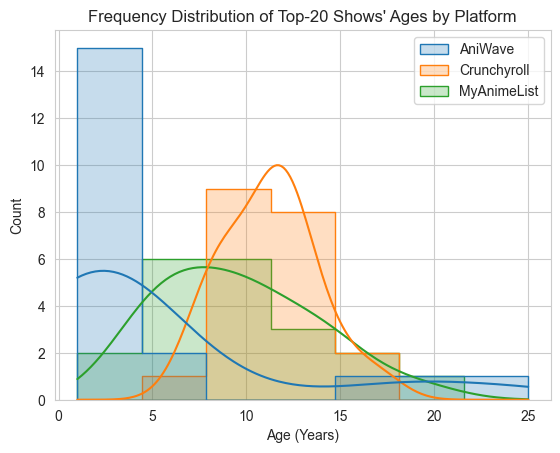

In [16]:
show_age_hist = sns.histplot(t20_ages, kde=True, element="step")
show_age_hist.set_xlabel('Age (Years)')
show_age_hist.set_title('Frequency Distribution of Top-20 Shows\' Ages by Platform')

### Score by Genre by Site

Index(['genre_action', 'genre_adventure', 'genre_comedy', 'genre_drama',
       'genre_family', 'genre_fantasy', 'genre_food', 'genre_harem',
       'genre_historical', 'genre_horror', 'genre_idols', 'genre_isekai',
       'genre_jdrama', 'genre_magical girls', 'genre_martial arts',
       'genre_mecha', 'genre_music', 'genre_mystery', 'genre_post-apocalyptic',
       'genre_romance', 'genre_sci-fi', 'genre_seinen', 'genre_sgdrama',
       'genre_shojo', 'genre_shonen', 'genre_slice of life', 'genre_sports',
       'genre_supernatural', 'genre_thriller'],
      dtype='object')


/var/folders/6t/m8p7kvf97cd38j154jl_hcx00000gn/T/ipykernel_46345/1835008969.py:16: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  score_by_genre = pd.concat([score_by_genre, temp_df])


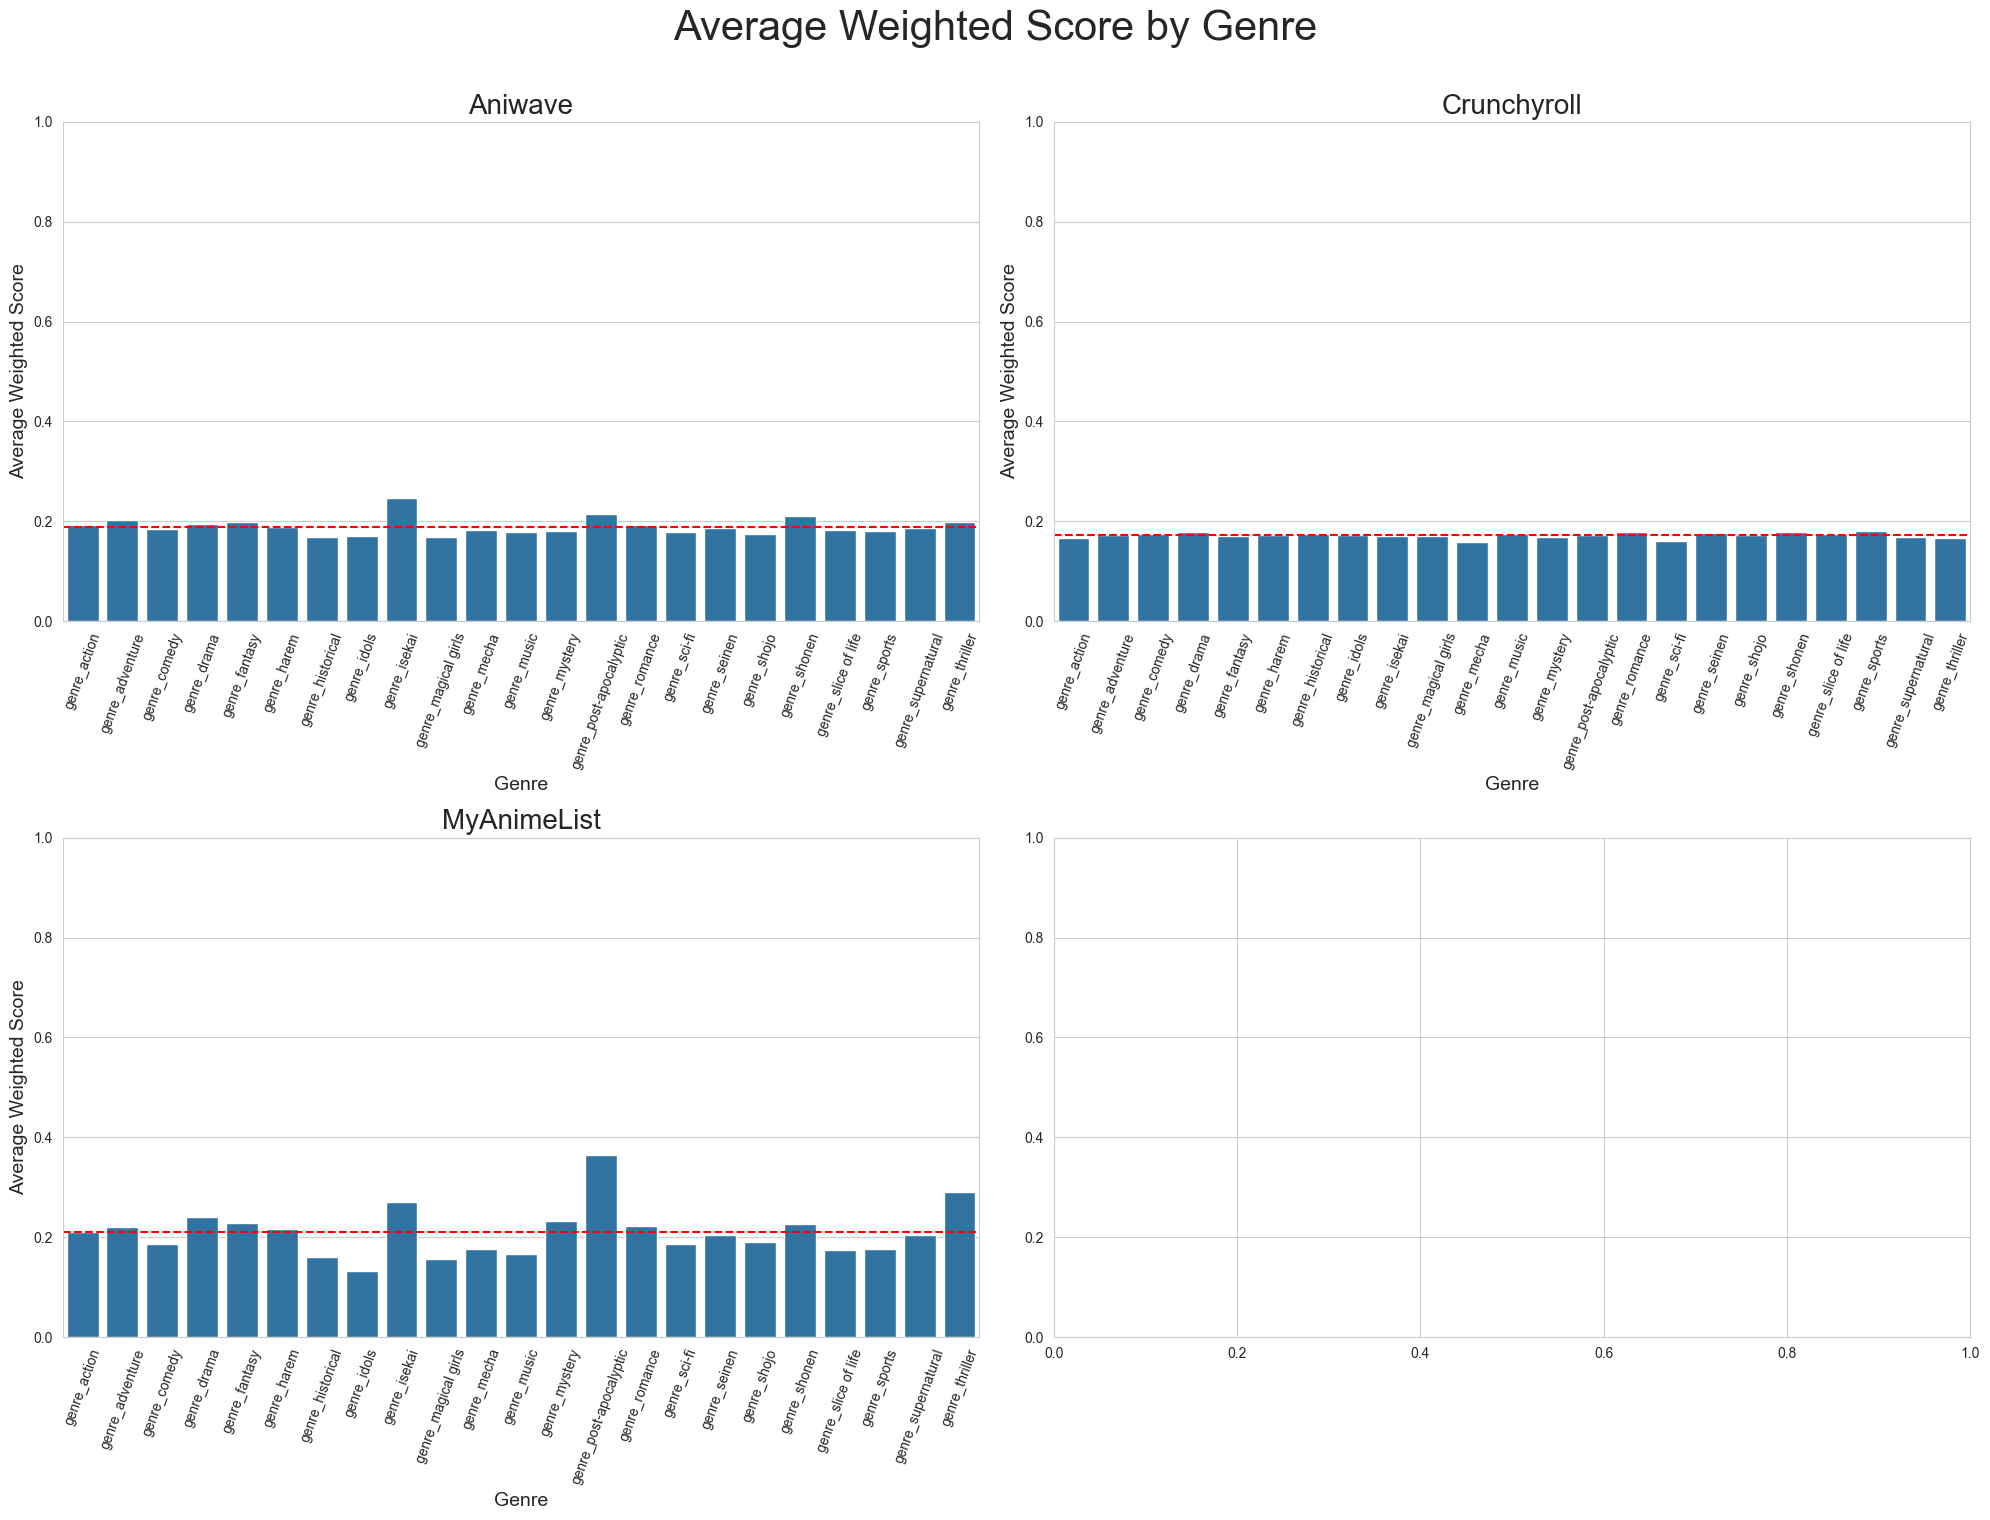

In [17]:
# get a list of genre names
genres = acm.filter(like='genre').columns
print(genres)

score_by_genre = pd.DataFrame(columns=['genre', 'ani_mean_score','cr_mean_score','mal_mean_score'])


# Visualize differences
for genre in genres:
    ani_mean_score = acm.loc[acm[genre]==1]['weighted_score_aw'].mean()
    cr_mean_score = acm.loc[acm[genre]==1]['weighted_score_cr'].mean()
    mal_mean_score = acm.loc[acm[genre]==1]['weighted_score_mal'].mean()
    
    temp_df = pd.DataFrame({'genre':[genre], 'ani_mean_score':[ani_mean_score], 'cr_mean_score':[cr_mean_score], 'mal_mean_score':[mal_mean_score]})
    #genre_mean_diff = genre_mean_diff.append(temp_df)
    score_by_genre = pd.concat([score_by_genre, temp_df])
    
# Filter out the genres with no instances
score_by_genre = score_by_genre.dropna()



# Plot charts
fig, axes= plt.subplots(2, 2, figsize=(20, 15))
plt.subplots_adjust(wspace=0.4, hspace=0.6)

sources = ['ani_mean_score','cr_mean_score','mal_mean_score']
sites = ['Aniwave', 'Crunchyroll', 'MyAnimeList']

for ax, source, site in zip(axes.flatten(), sources, sites):
    sns.barplot(data=score_by_genre, x='genre', y=source, ax=ax)
    ax.axhline(y=score_by_genre[source].mean(), color='red', linestyle='--', label='Average Weighted Score')


    ax.tick_params(axis='x', rotation=70) 
    ax.set_title(site, fontsize=20)
    ax.set_xlabel('Genre', fontsize=14)
    ax.set_ylabel('Average Weighted Score', fontsize=14)

    # Set  y-axis limits
    ax.set_ylim(0, 1)
    
fig.suptitle('Average Weighted Score by Genre', fontsize=30, y=1.01)
fig.savefig('graphs/acm_score_byGenre', bbox_inches='tight')        

plt.tight_layout()
plt.show()  

### Score by Episodes

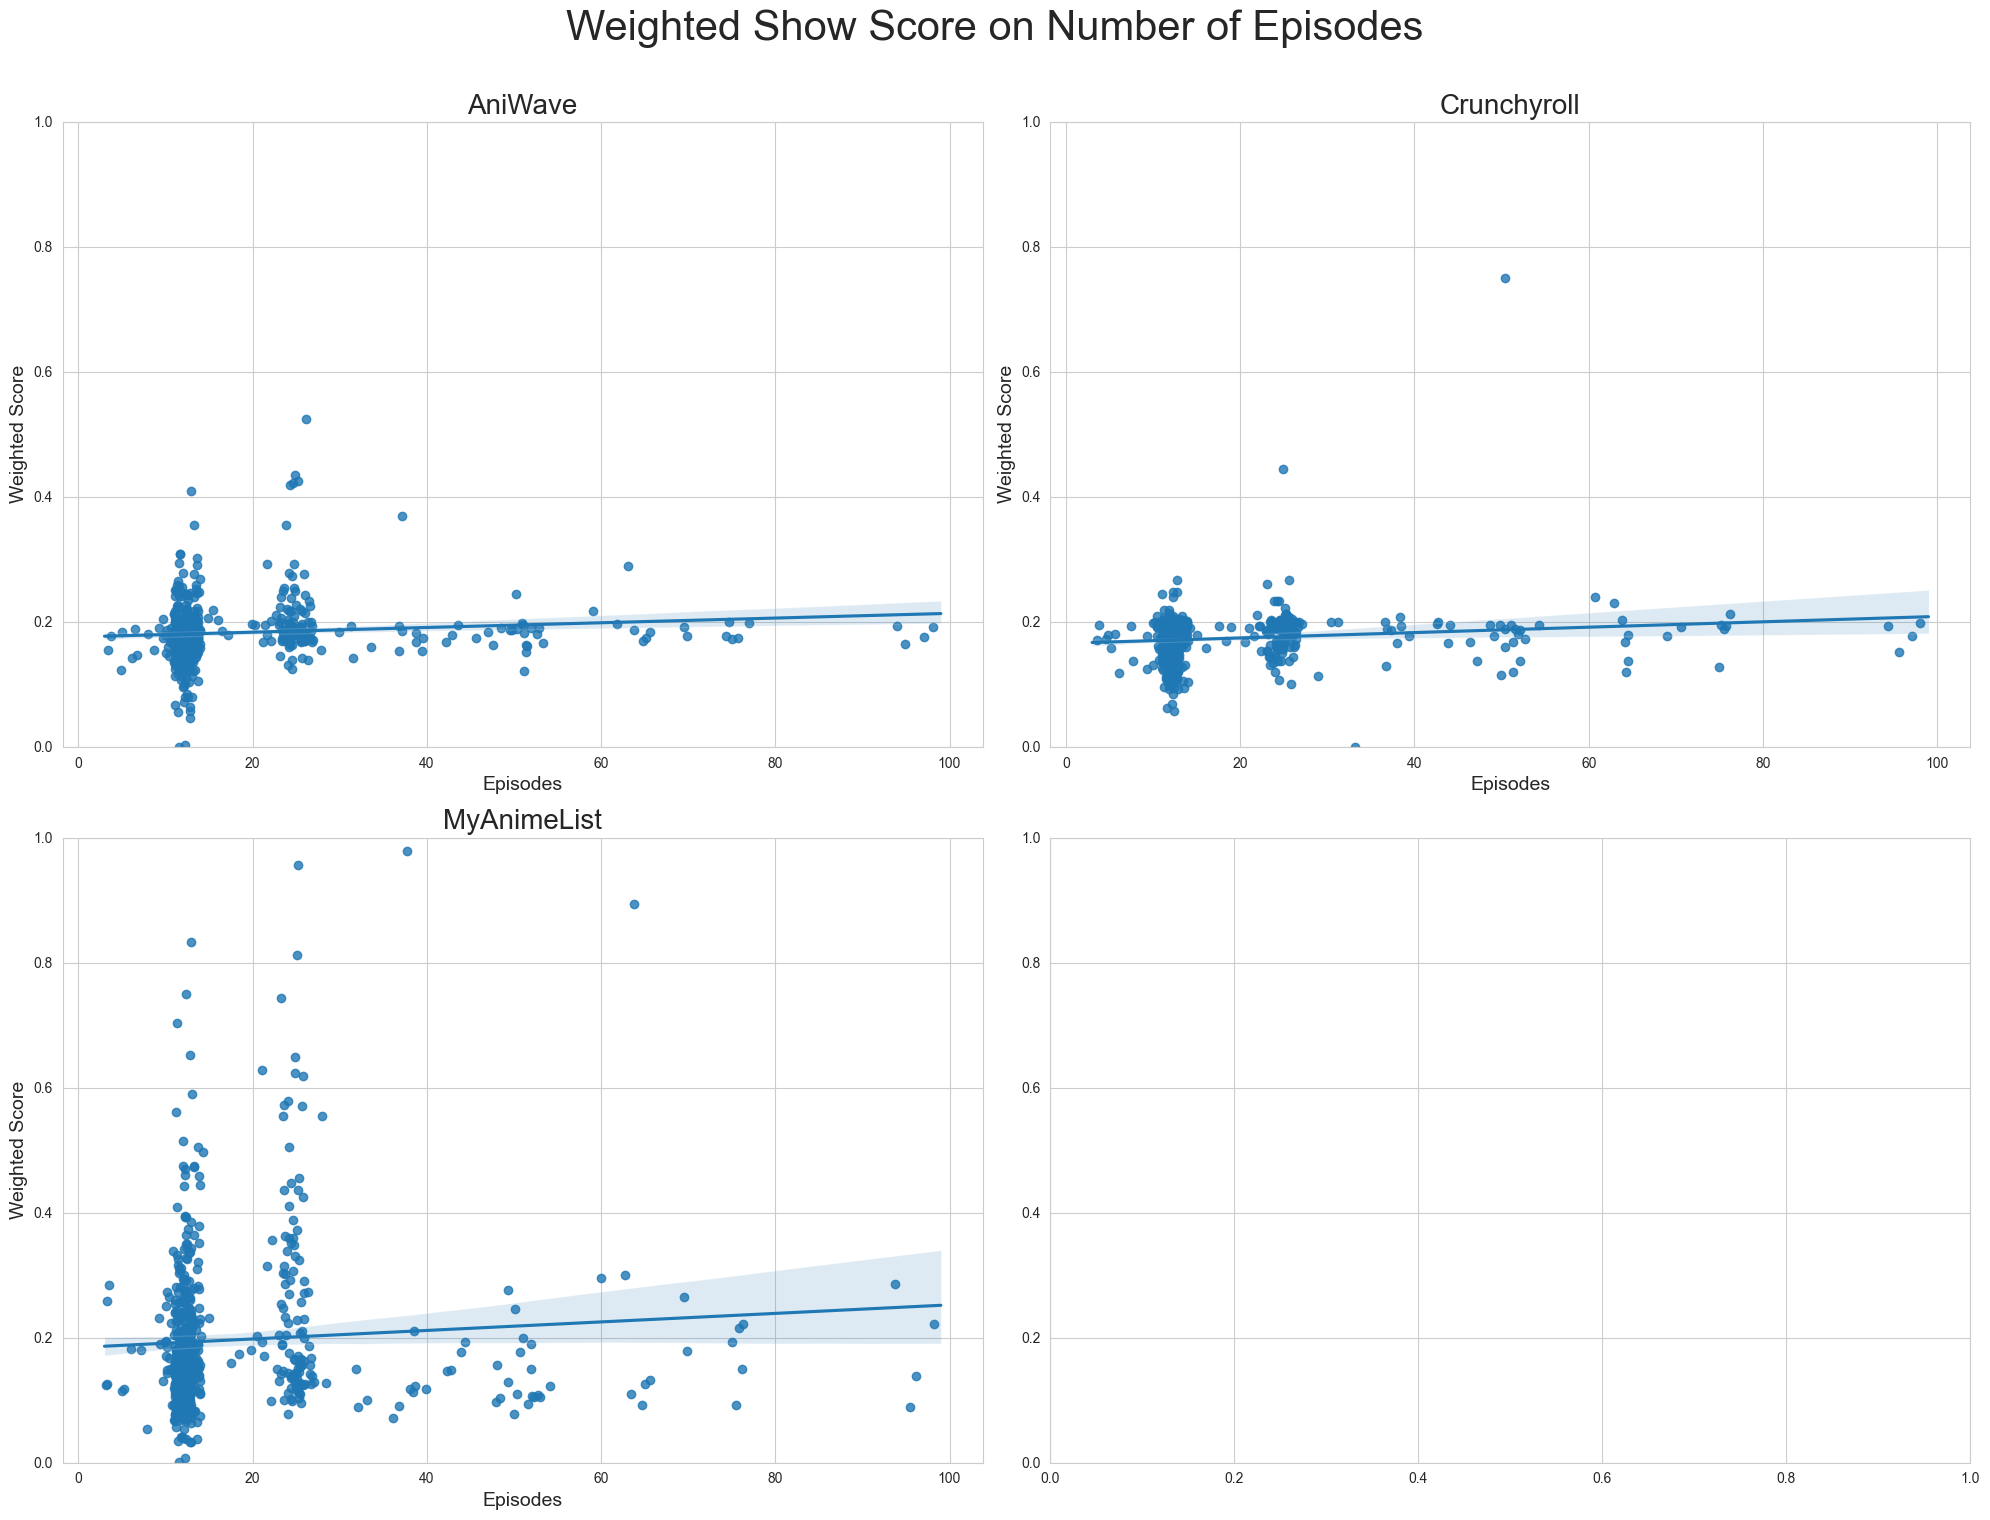

In [23]:
acm['episodes'].max()

fig, axes = plt.subplots(2, 2, figsize=(20, 15))

weighted_scores = ['weighted_score_aw', 'weighted_score_cr', 'weighted_score_mal']
sites = ['AniWave', 'Crunchyroll', 'MyAnimeList']
for ax, weighted_score, site in zip(axes.flatten(), weighted_scores, sites):
    x= acm['episodes'][acm['episodes']<100] # Only look at shows with a "standard" number of episodes
    y= acm[weighted_score][acm['episodes']<100]
    sns.regplot(x=x, y=y, ax=ax,)
   
    ax.set_title(site, fontsize=20)
    ax.set_xlabel('Episodes', fontsize=14)
    ax.set_ylabel('Weighted Score', fontsize=14)

    # Set  y-axis limits
    ax.set_ylim(0, 1)

fig.suptitle('Weighted Show Score on Number of Episodes', fontsize=30, y=1.01)
fig.savefig('graphs/acm_score_byEpisodes', bbox_inches='tight')        
plt.tight_layout()
plt.show()  

### Score by Age

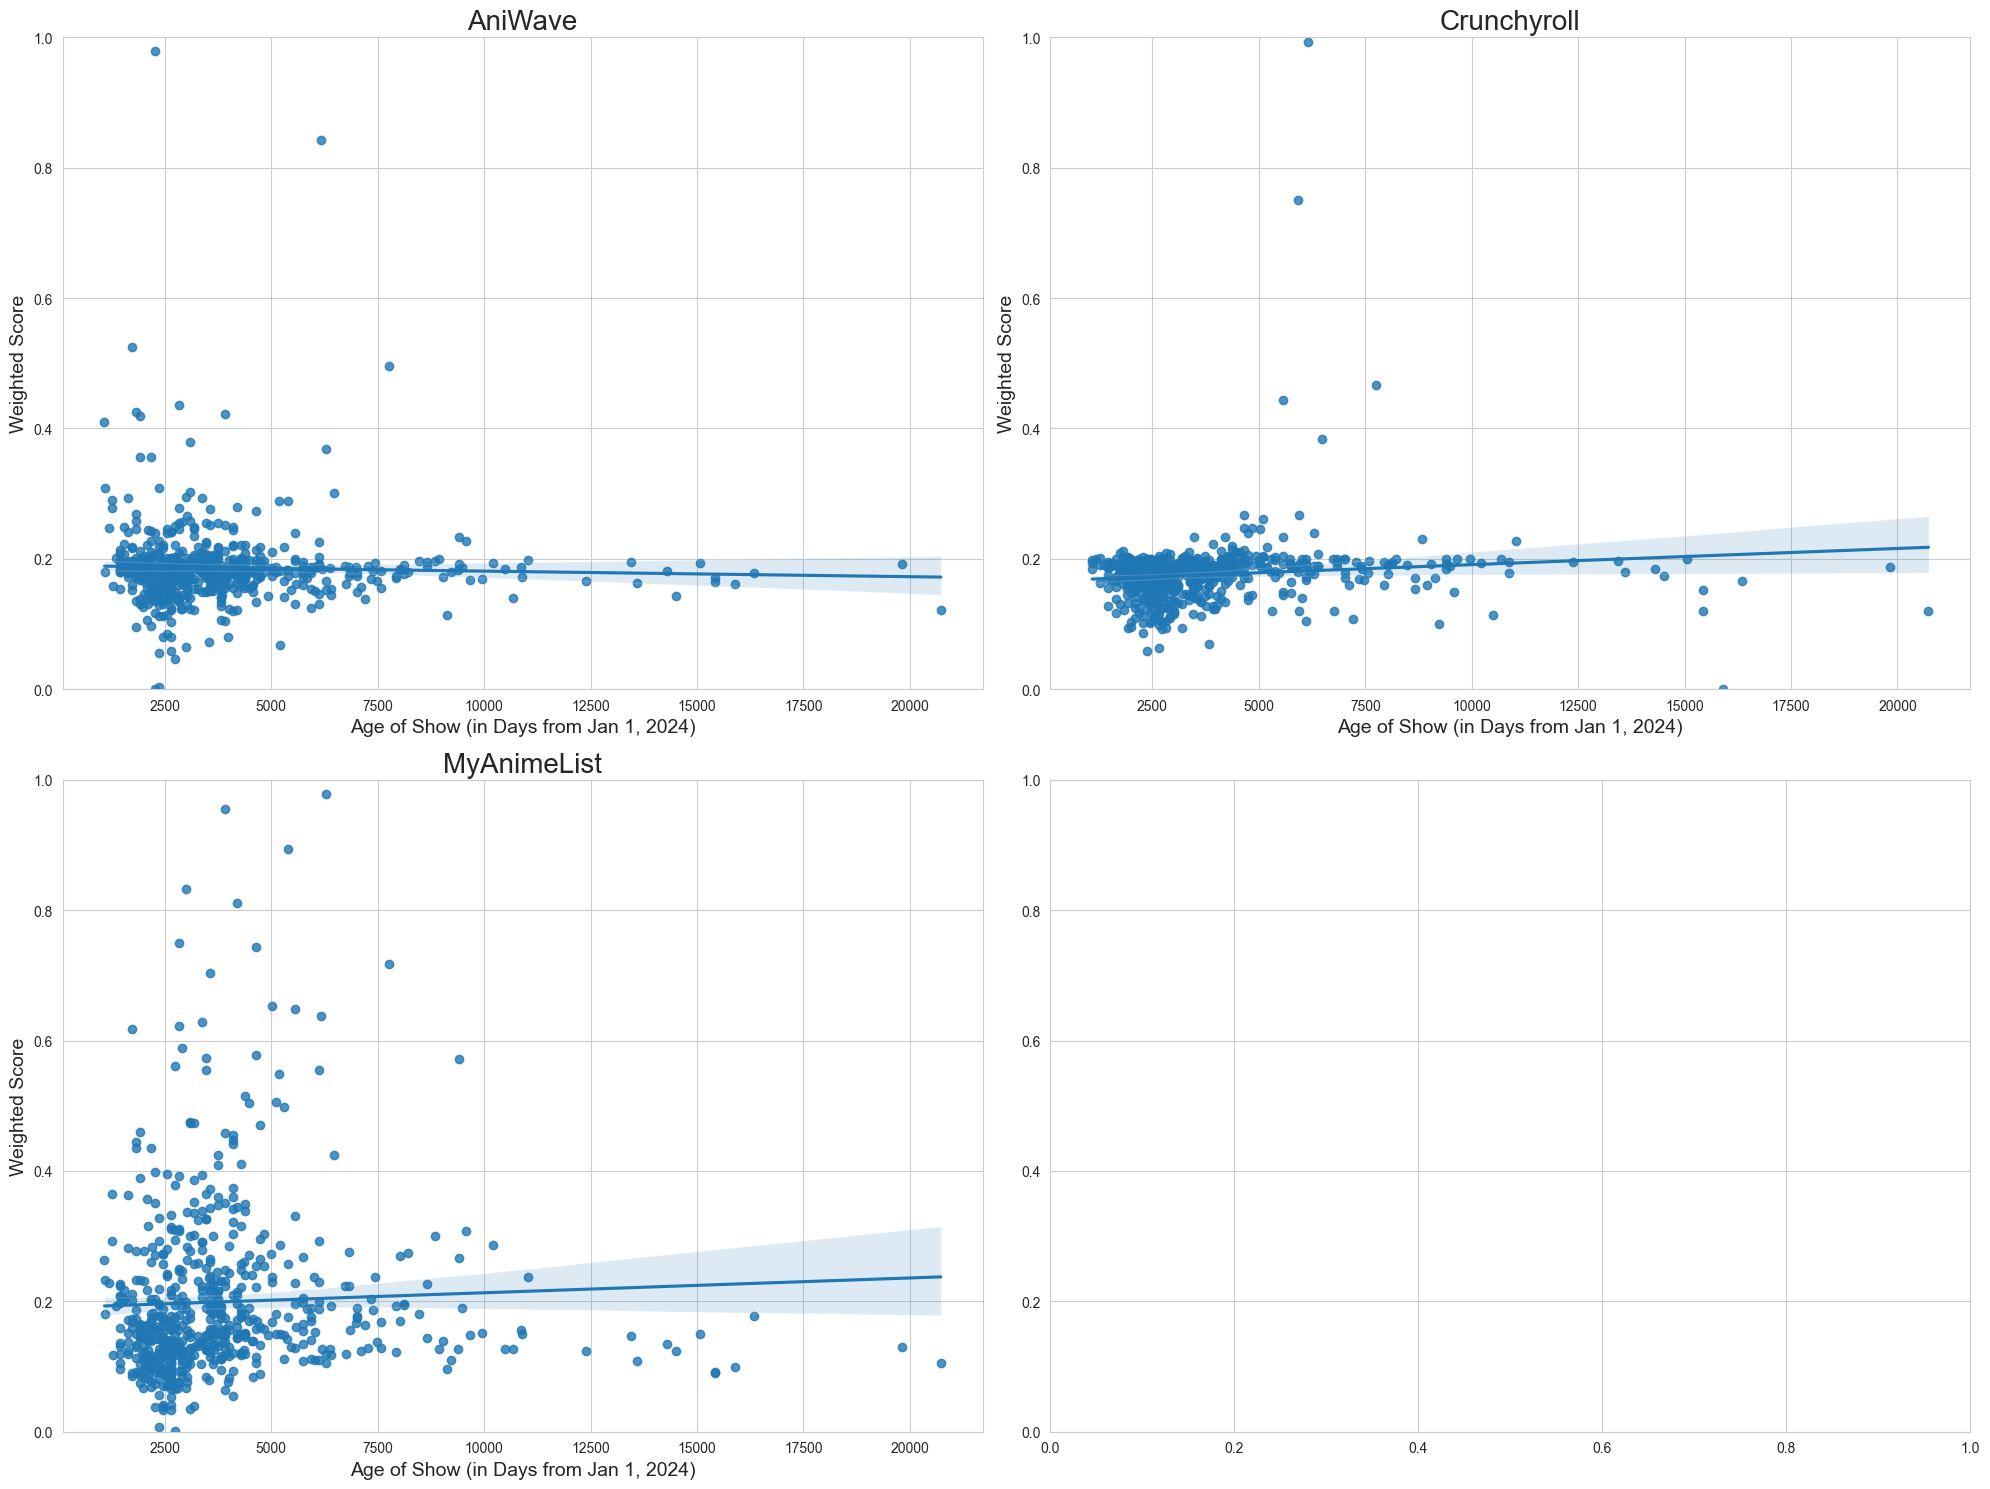

In [20]:
fig, axes = plt.subplots(2, 2, figsize=(20, 15))

weighted_scores = ['weighted_score_aw', 'weighted_score_cr', 'weighted_score_mal']
sites = ['AniWave', 'Crunchyroll', 'MyAnimeList']
for ax, weighted_score, site in zip(axes.flatten(), weighted_scores, sites):
    x= acm['show_age']
    y= acm[weighted_score]
    sns.regplot(x=x, y=y, ax=ax)
   
    ax.set_title(site, fontsize=20)
    ax.set_xlabel('Age of Show (in Days from Jan 1, 2024)', fontsize=14)
    ax.set_ylabel('Weighted Score', fontsize=14)

    # Set  y-axis limits
    ax.set_ylim(0, 1)

fig.savefig('graphs/acm_score_byAge', bbox_inches='tight')        
plt.tight_layout()
plt.show()  


## Scores by Controversy

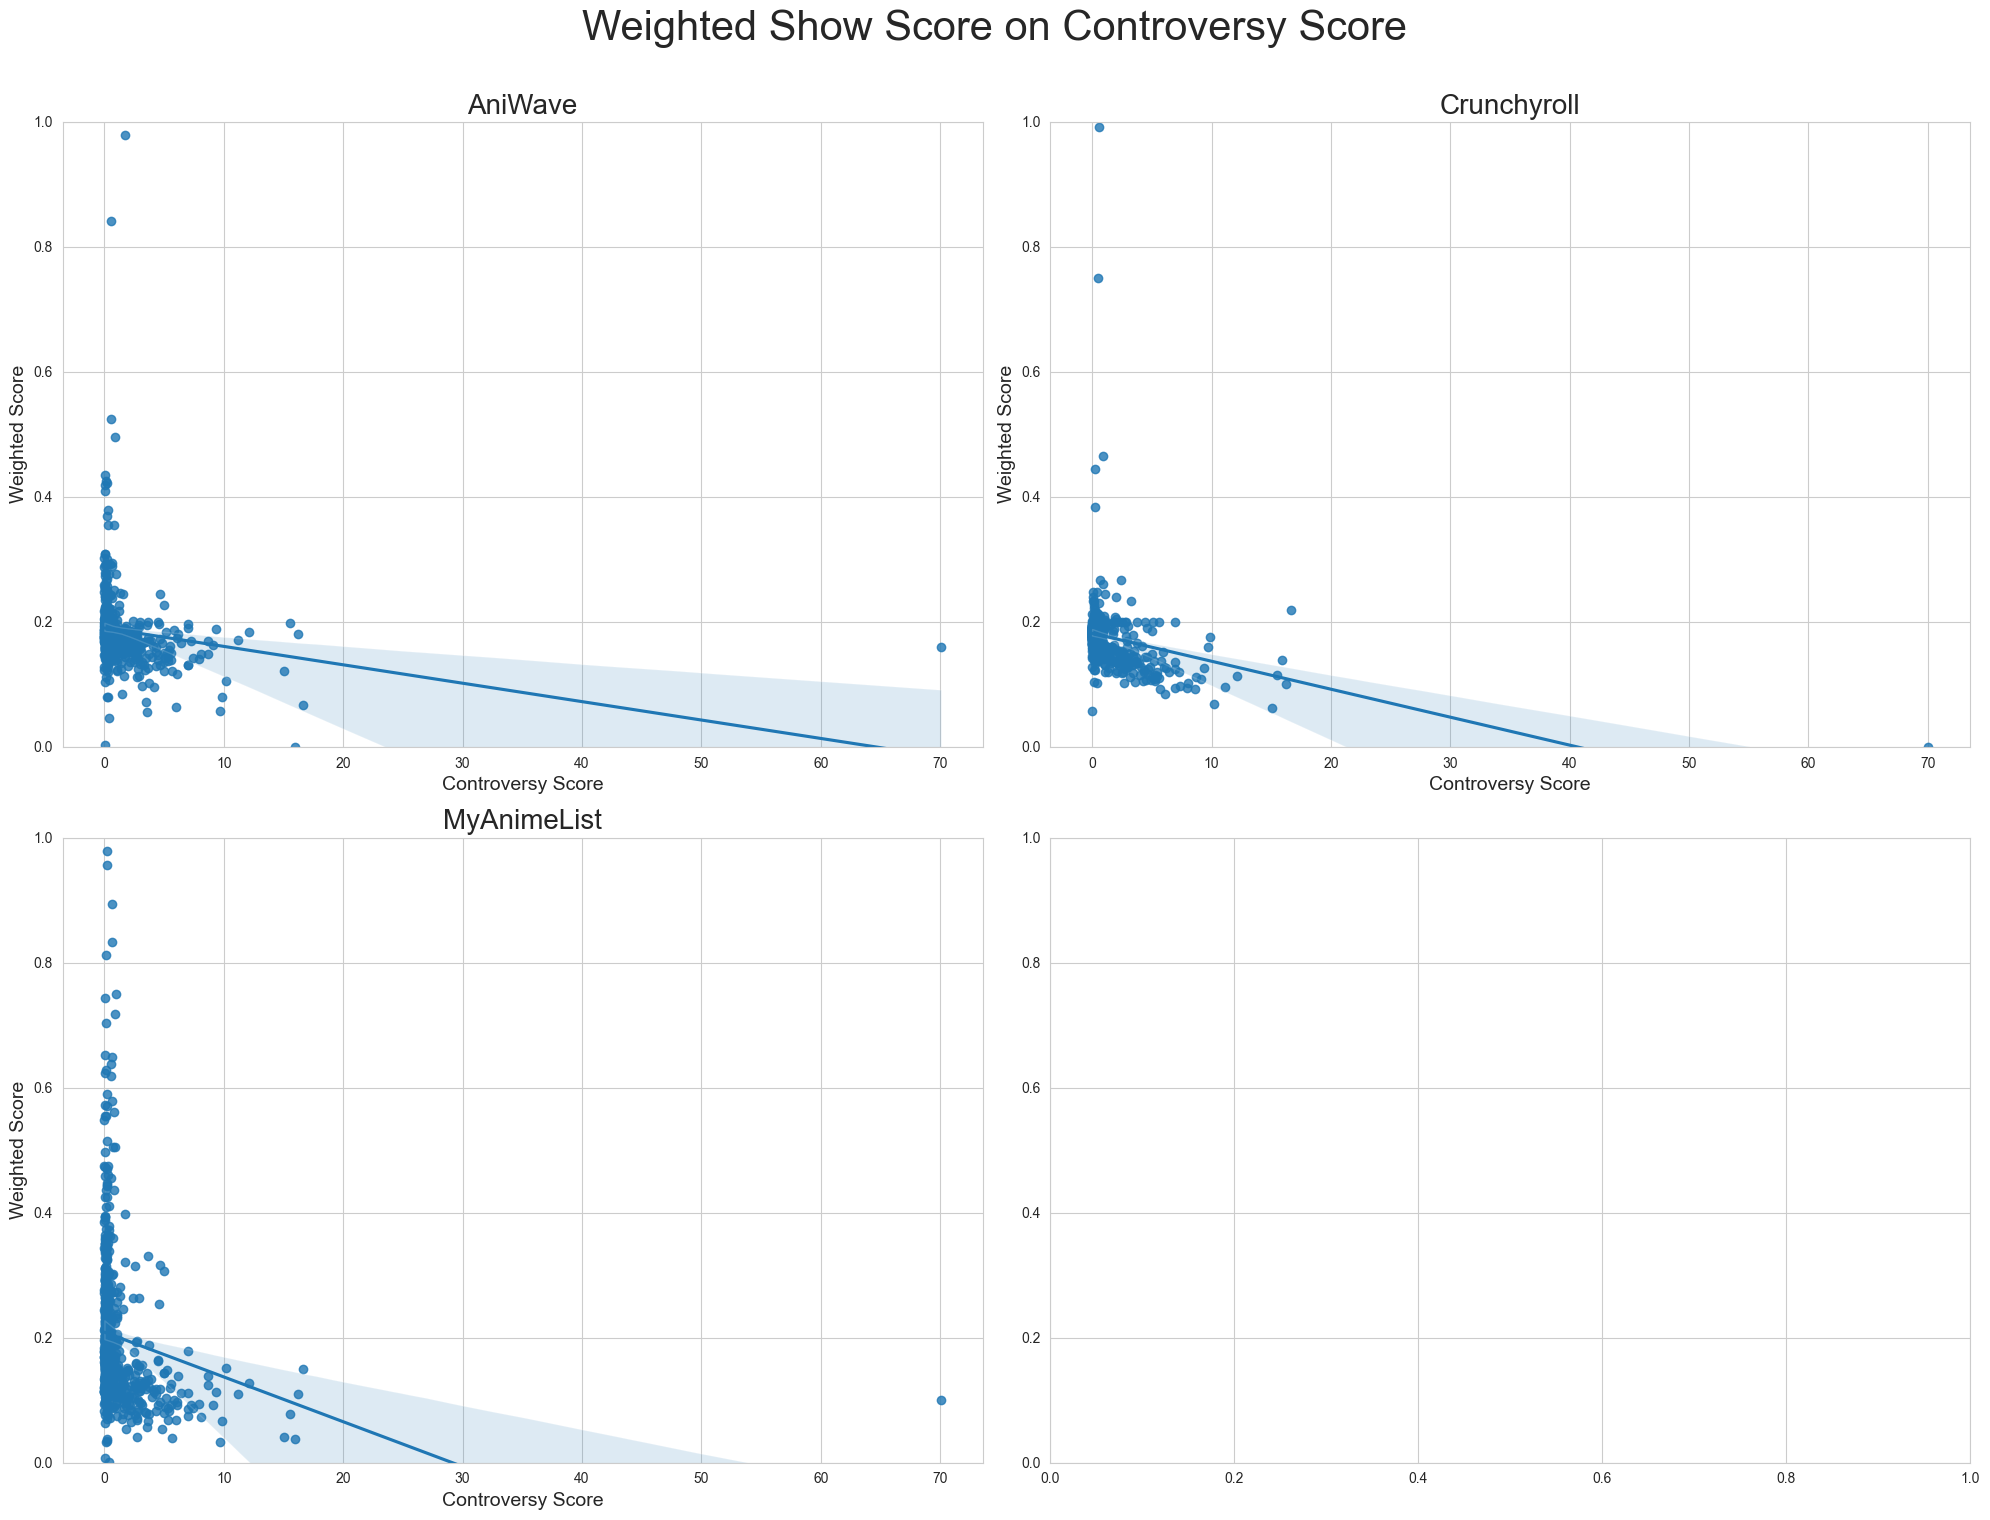

In [31]:
fig, axes = plt.subplots(2, 2, figsize=(20, 15))

weighted_scores = ['weighted_score_aw', 'weighted_score_cr', 'weighted_score_mal']
sites = ['AniWave', 'Crunchyroll', 'MyAnimeList']
for ax, site, weighted_score in zip(axes.flatten(), sites, weighted_scores):
    x= acm['controversy']
    y= acm[weighted_score]
    sns.regplot(x=x, y=y, ax=ax)
   
    ax.set_title(site, fontsize=20)
    ax.set_xlabel('Controversy Score', fontsize=14) # This is the SQUARED difference in rating score
    ax.set_ylabel('Weighted Score', fontsize=14)

    # Set  y-axis limits
    ax.set_ylim(0, 1)
     
fig.suptitle('Weighted Show Score on Controversy Score', fontsize=30, y=1.01)
plt.tight_layout()
plt.show()  

In [45]:
most_controversial = acm[['anime','controversy', 'rating_aw', 'rating_cr', 'votes_aw', 'votes_cr']].sort_values(by='controversy', ascending=False).head(20)
most_controversial.to_excel('data_tables/most_controversial.xlsx')
print(most_controversial[['votes_aw', 'votes_cr']].mean())


votes_aw    436.25
votes_cr    158.50
dtype: float64


In [54]:
most_controversial_20 = acm[['anime','controversy', 'rating_aw', 'rating_cr', 'votes_aw', 'votes_cr']].sort_values(by='controversy', ascending=False).head(20)
#most_controversial.to_excel('data_tables/most_controversial.xlsx')
print(most_controversial_20[['rating_aw', 'rating_cr']].mean())

most_controversial_100 = acm[['anime','controversy', 'rating_aw', 'rating_cr', 'votes_aw', 'votes_cr']].sort_values(by='controversy', ascending=False).head(100)
#most_controversial.to_excel('data_tables/most_controversial.xlsx')
print(most_controversial_100[['rating_aw', 'rating_cr']].mean())

rating_aw    7.5165
rating_cr    5.4370
dtype: float64
rating_aw    7.8497
rating_cr    6.6638
dtype: float64


In [36]:
av_votes_aw = acm['votes_aw'].mean()
print(av_votes_aw)
av_votes_cr = acm['votes_cr'].mean()
print(av_votes_cr)

1920.5248796147673
436.346709470305


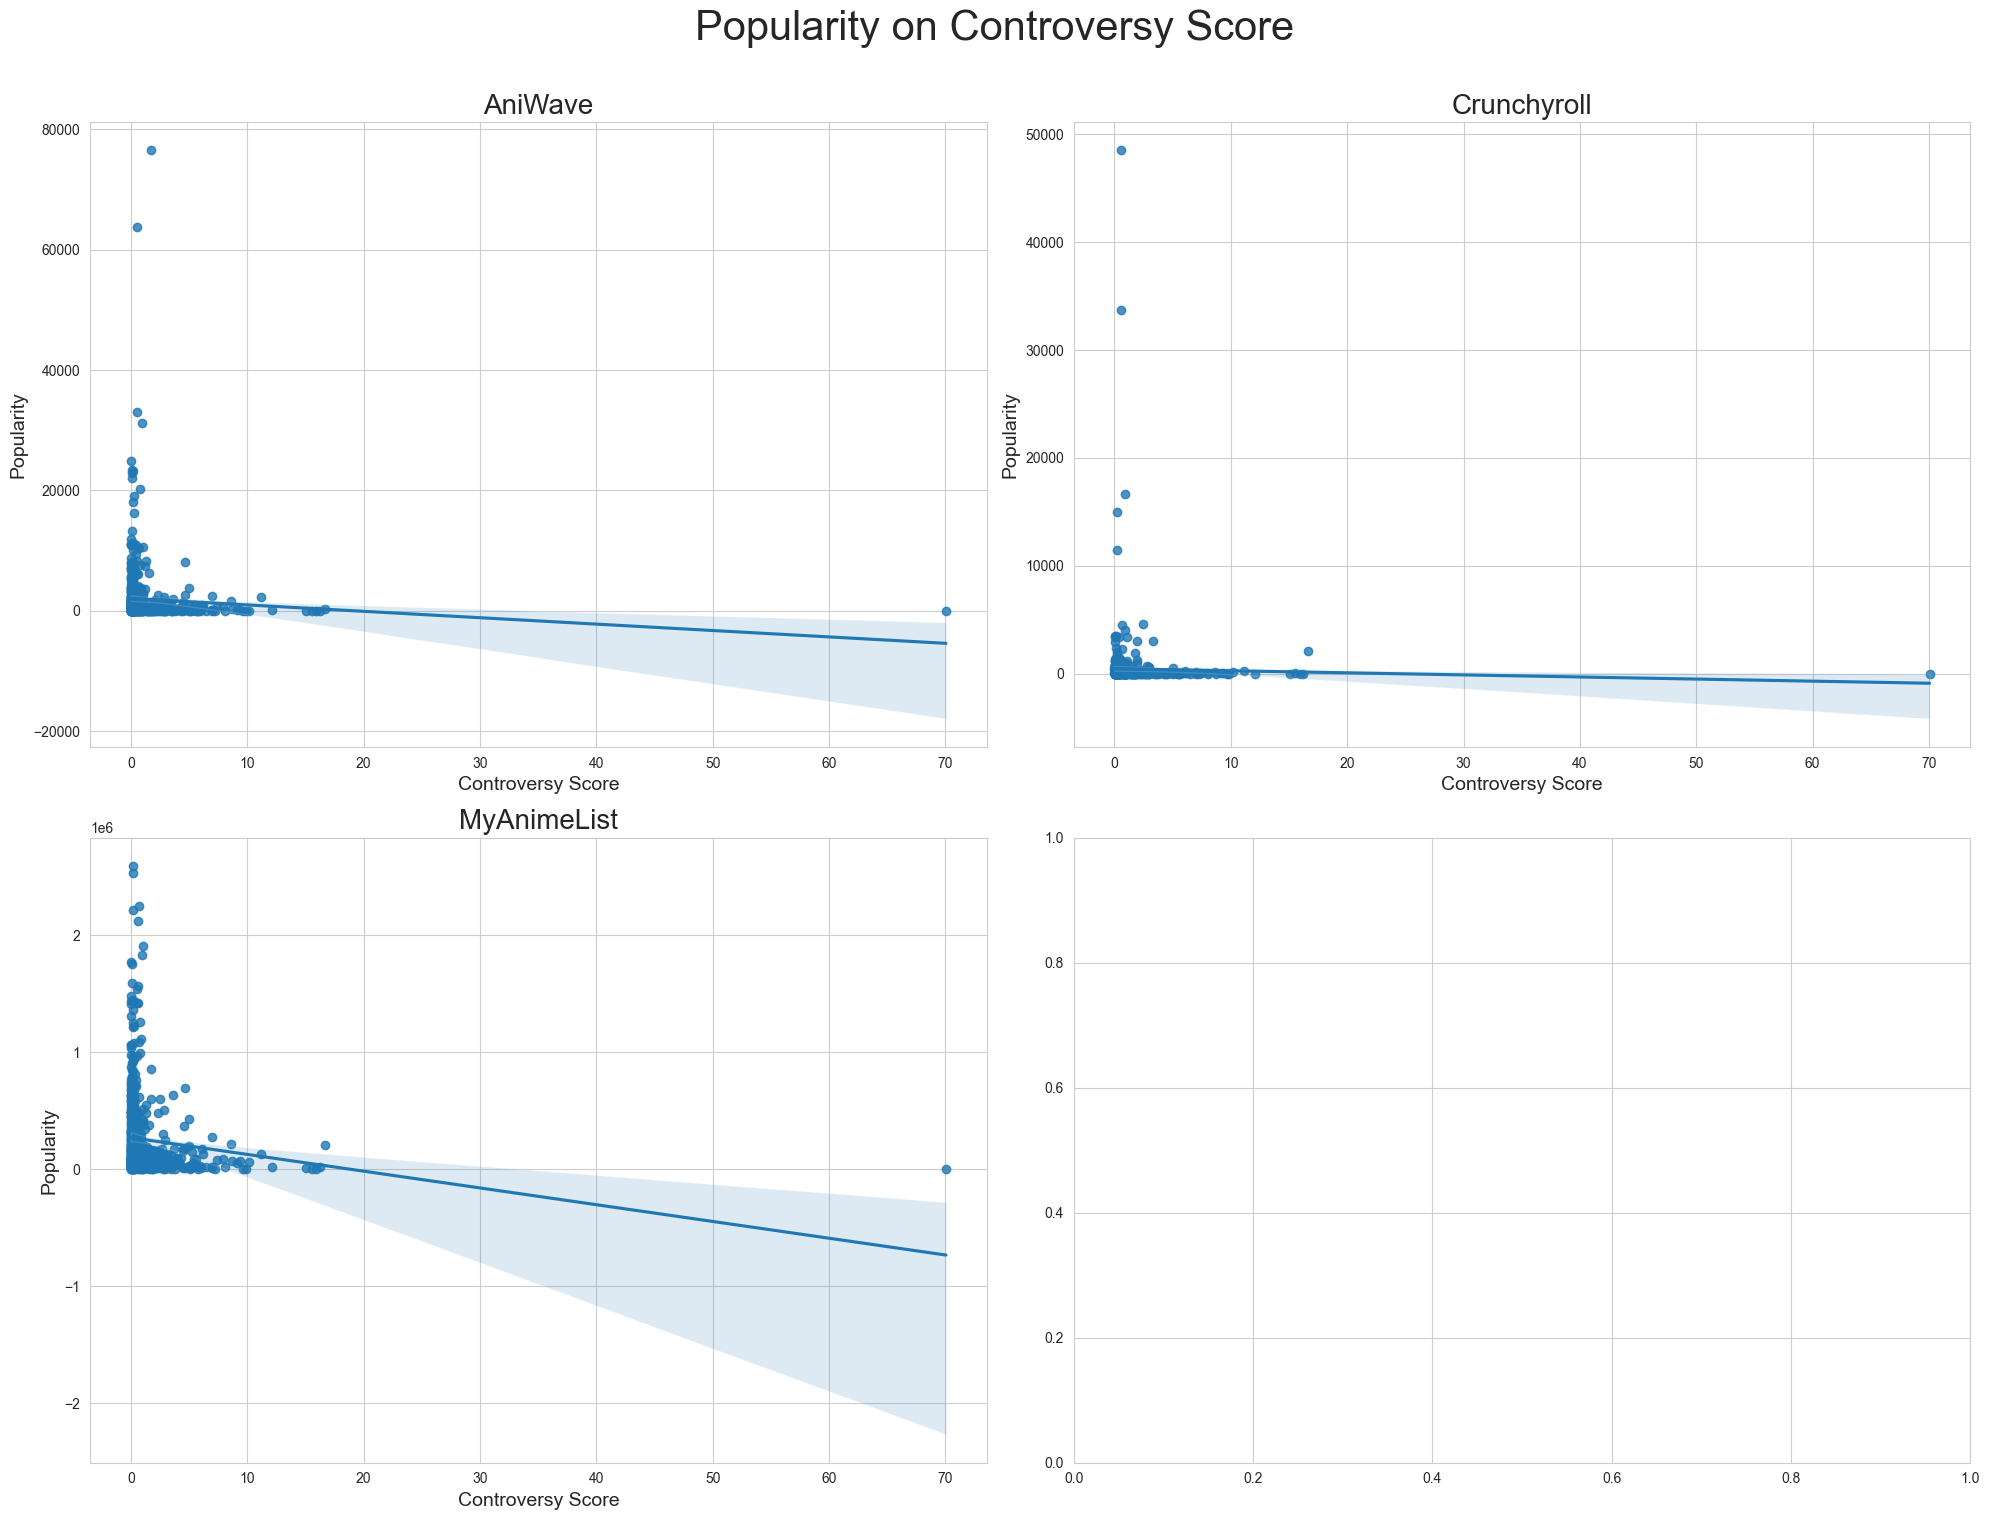

In [43]:
fig, axes = plt.subplots(2, 2, figsize=(20, 15))

votes = ['votes_aw', 'votes_cr', 'members']
sites = ['AniWave', 'Crunchyroll', 'MyAnimeList']
for ax, site, vote in zip(axes.flatten(), sites, votes):
    x= acm['controversy']
    y= acm[vote]
    sns.regplot(x=x, y=y, ax=ax)
   
    ax.set_title(site, fontsize=20)
    ax.set_xlabel('Controversy Score', fontsize=14) # This is the SQUARED difference in rating score
    ax.set_ylabel('Popularity', fontsize=14)

    # Set  y-axis limits
    #ax.set_ylim(0, 1)
     
fig.suptitle('Popularity on Controversy Score', fontsize=30, y=1.01)
plt.tight_layout()
plt.show()  

### Score by Source

,AniWave,Crunchyroll,MyAnimeList
source,,,
4-koma manga,0.177888,0.171040,0.151176
Book,0.173282,0.179324,0.117461
Card game,0.170801,0.155757,0.106500
Digital manga,0.146318,0.134785,0.102096
Game,0.156519,0.152426,0.111987
Light novel,0.206189,0.175622,0.268101
Manga,0.196314,0.188676,0.218094
Music,0.176426,0.175322,0.176293
Novel,0.178018,0.179780,0.183499


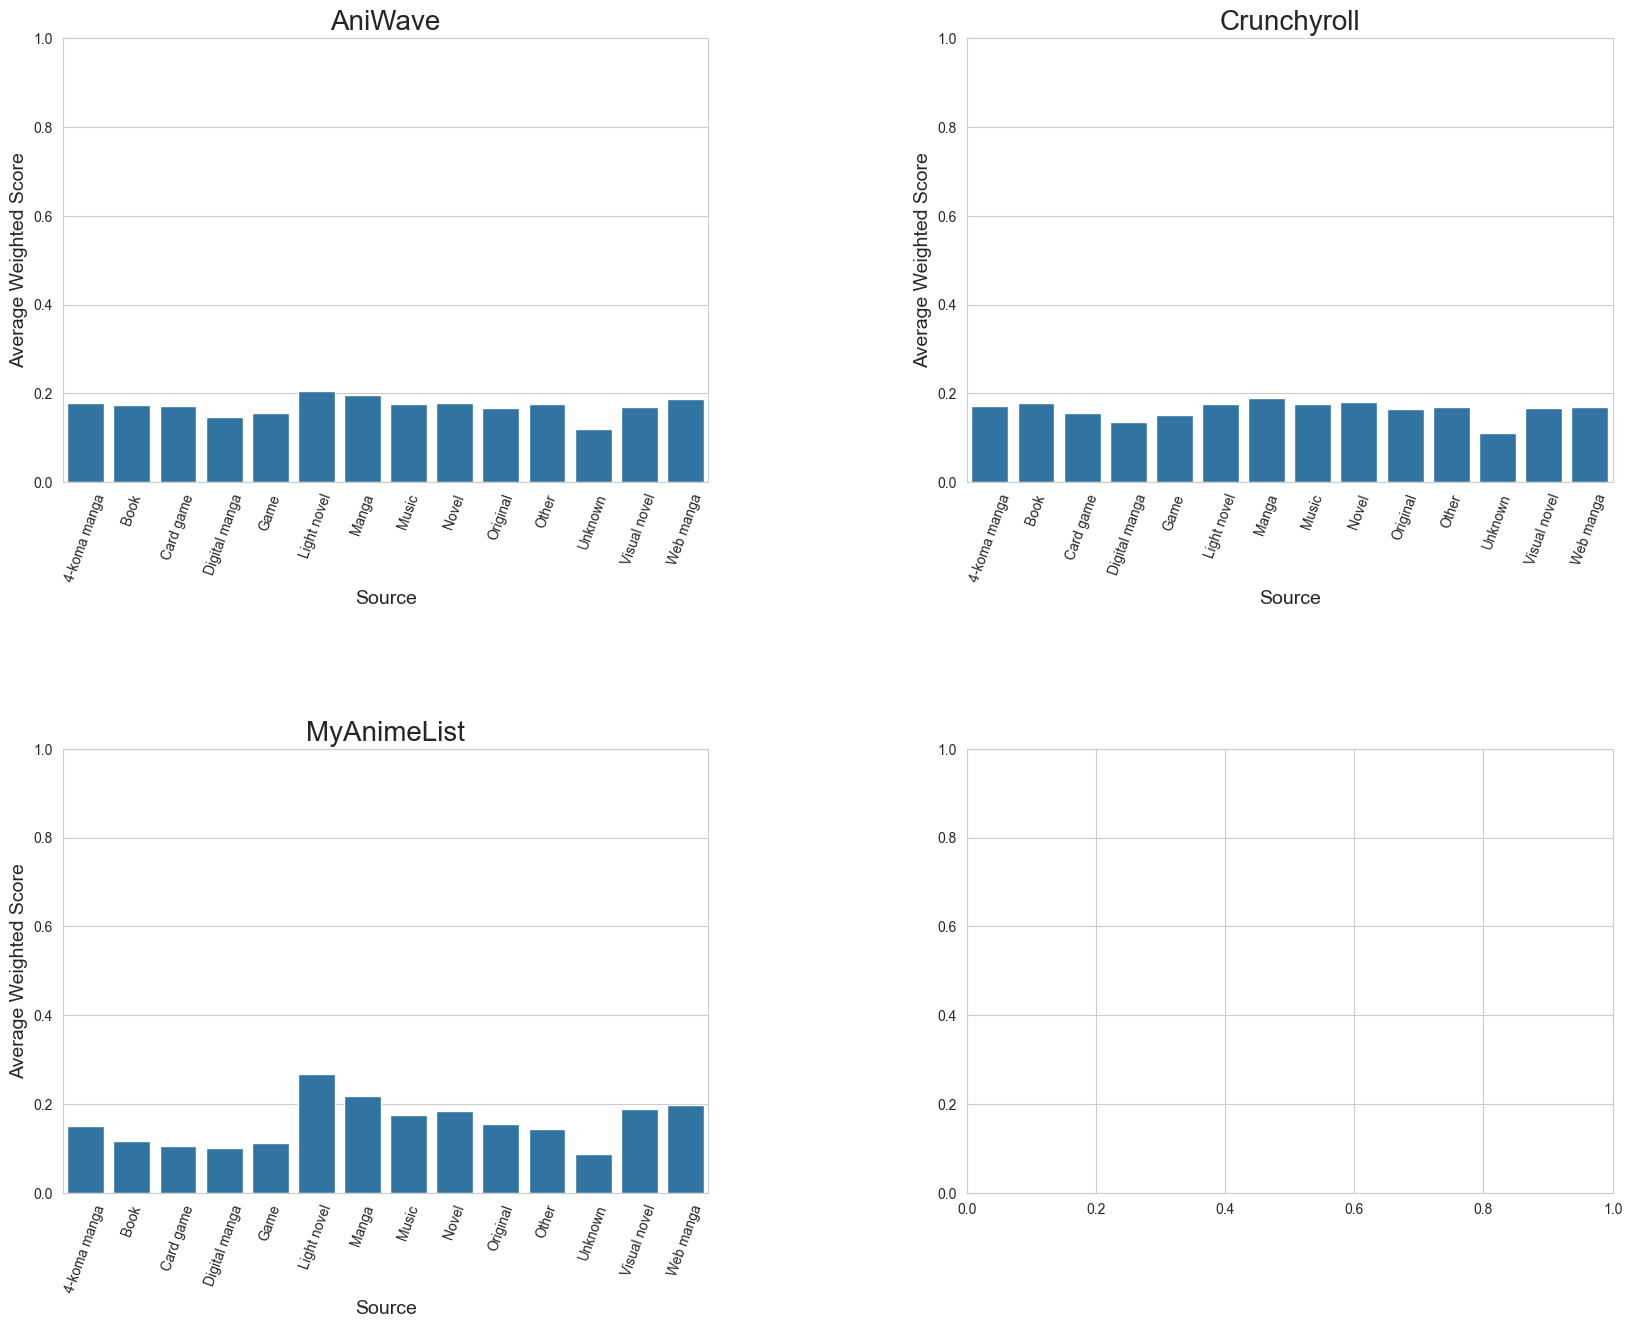

In [253]:
# Group by source 
popularity_by_source = pd.DataFrame(columns=['AniWave', 'Crunchyroll', 'MyAnimeList'])

# Find average score for each group for each streaming source
popularity_by_source['AniWave'] = acm.groupby('source')['weighted_score_aw'].mean()
popularity_by_source['Crunchyroll'] = acm.groupby('source')['weighted_score_cr'].mean()
popularity_by_source['MyAnimeList'] = acm.groupby('source')['weighted_score_mal'].mean()

display(popularity_by_source)

# Plot charts
fig, axes = plt.subplots(2, 2, figsize=(20, 15))
plt.subplots_adjust(wspace=0.4, hspace=0.6)

sites = ['AniWave', 'Crunchyroll', 'MyAnimeList']
for ax, site in zip(axes.flatten(), sites):
    sns.barplot(data=popularity_by_source, x='source', y=site, ax=ax)
    ax.tick_params(axis='x', rotation=70) 

    ax.set_title(site, fontsize=20)
    ax.set_xlabel('Source', fontsize=14)
    ax.set_ylabel('Average Weighted Score', fontsize=14)

    # Set  y-axis limits
    ax.set_ylim(0, 1)

    
fig.savefig('graphs/acm_score_bySource', bbox_inches='tight')   

# Prediction

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler # DEAL WITH OUTLIERS
import math
acm_preprocess = acm.copy()
print(acm_preprocess.keys())

Index(['Unnamed: 0', 'anime', 'rating_aw', 'rating_cr', 'rating_mal',
       'votes_aw', 'votes_cr', 'members', 'popularity', 'ranked', 'start_date',
       'episodes', 'producers', 'licensors', 'studios', 'source', 'rating',
       'genre_action', 'genre_adventure', 'genre_comedy', 'genre_drama',
       'genre_family', 'genre_fantasy', 'genre_food', 'genre_harem',
       'genre_historical', 'genre_horror', 'genre_idols', 'genre_isekai',
       'genre_jdrama', 'genre_magical girls', 'genre_martial arts',
       'genre_mecha', 'genre_music', 'genre_mystery', 'genre_post-apocalyptic',
       'genre_romance', 'genre_sci-fi', 'genre_seinen', 'genre_sgdrama',
       'genre_shojo', 'genre_shonen', 'genre_slice of life', 'genre_sports',
       'genre_supernatural', 'genre_thriller', 'ani_crunch_diff',
       'mal_ani_diff', 'mal_crunch_diff', 'show_age', 'controversy',
       'weighted_score_aw', 'weighted_score_cr', 'weighted_score_mal',
       'Category_4-koma manga', 'Category_Book', 'Cate

### Preprocessing

In [20]:
# Separate explanatory and response variables
genres = acm_preprocess.filter(like='genre').columns
sources = acm_preprocess.filter(like='Category').columns

# Reduce dimensionality for genres
for genre in genres:
    if (acm_preprocess[genre].sum() ==0):
        acm_preprocess.drop(columns=genre, inplace=True)
genres = acm_preprocess.filter(like='genre').columns


# Label ratings
mapping = {'G - All Ages':0, 'PG - Children':1, 'PG-13 - Teens 13 or older':2, 'R - 17+ (violence & profanity)':3, 'R+ - Mild Nudity':4}
acm_preprocess['rating'] = acm_preprocess['rating'].map(mapping, na_action='ignore')

# AniWave
X_aw = acm_preprocess[['weighted_score_cr', 'weighted_score_mal', 'show_age', 'controversy', 'episodes', *genres, *sources]]
y_aw = acm_preprocess['weighted_score_aw']

#crunchyroll
X_cr = acm_preprocess[['weighted_score_aw', 'weighted_score_mal', 'show_age', 'controversy', 'episodes', *genres, *sources]]
y_cr = acm_preprocess['weighted_score_cr']

#MyAnimeList
X_mal = acm_preprocess[['weighted_score_aw', 'weighted_score_cr', 'show_age', 'controversy', 'episodes', *genres, *sources]]
y_mal = acm_preprocess['weighted_score_mal']

# Normalize
scaler = RobustScaler()
X_aw = pd.DataFrame(scaler.fit_transform(X_aw), columns=X_aw.columns)
X_cr = pd.DataFrame(scaler.fit_transform(X_cr), columns=X_cr.columns)
X_mal = pd.DataFrame(scaler.fit_transform(X_mal), columns=X_mal.columns)

### Train and Test Split

In [21]:
# Create train-test split
X_aw_train, X_aw_test, y_aw_train, y_aw_test = train_test_split(X_aw, y_aw, test_size=0.3)
X_cr_train, X_cr_test, y_cr_train, y_cr_test = train_test_split(X_cr, y_cr, test_size=0.3)
X_mal_train, X_mal_test, y_mal_train, y_mal_test = train_test_split(X_cr, y_cr, test_size=0.3)

In [22]:
# Import metric reporting tools
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

## Lasso Regression

In [23]:
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV

### AniWave - Lasso

In [48]:
# Basic performance (alpha = 1.0)
lasso_aw = Lasso()
lasso_aw.fit(X_aw_train, y_aw_train)

y_aw_pred = lasso_aw.predict(X_aw_test)
mse = mean_squared_error(y_aw_test, y_aw_pred)
r2 = r2_score(y_aw_test, y_aw_pred)
print(mse)
print(r2)

0.0023552728201718253
-0.016729832502446085


In [49]:
# Fine-tune hyperparameters: ROUND 1
alphas = [0.001, 0.01, 0.1, 1, 10, 100]

lasso_aw = Lasso()
param_grid = {'alpha': alphas}

grid_search_lasso = GridSearchCV(estimator=lasso_aw, param_grid=param_grid, cv=10)  # Use 10-fold cross-validation
grid_search_lasso.fit(X_aw_train, y_aw_train)
best_alpha = grid_search_lasso.best_params_['alpha']
print('Best alpha: ' + str(best_alpha))

Best alpha: 0.01


In [50]:
# Fine-tune hyperparameters: ROUND 2
alphas = [0.01, 0.03, 0.05, 0.07, 0.09]

lasso_aw = Lasso()
param_grid = {'alpha': alphas}

grid_search_lasso = GridSearchCV(estimator=lasso_aw, param_grid=param_grid, cv=10)  # Use 10-fold cross-validation
grid_search_lasso.fit(X_aw_train, y_aw_train)
best_alpha = grid_search_lasso.best_params_['alpha']
print('Best alpha: ' + str(best_alpha))

Best alpha: 0.01


In [24]:
# Best model
lasso_aw = Lasso(alpha=0.01)
lasso_aw.fit(X_aw_train, y_aw_train)
y_aw_pred = lasso_aw.predict(X_aw_test)
mse = mean_squared_error(y_aw_test, y_aw_pred)
r2 = r2_score(y_aw_test, y_aw_pred)
print(mse)
print(r2)

0.003953019199868361
0.3034599997534274


### Crunchyroll - Lasso

In [52]:
# Basic performance (alpha = 1.0)
lasso_cr = Lasso()
lasso_cr.fit(X_cr_train, y_cr_train)

y_cr_pred = lasso_cr.predict(X_cr_test)
mse = mean_squared_error(y_cr_test, y_cr_pred)
r2 = r2_score(y_cr_test, y_cr_pred)
print(mse)
print(r2)

0.004813838213280405
-0.0017069820944115577


In [59]:
# Fine-tune hyperparameters: ROUND 1
alphas = [0.001, 0.01, 0.1, 1, 10, 100]

lasso_cr = Lasso()
param_grid = {'alpha': alphas}

grid_search_lasso = GridSearchCV(estimator=lasso_cr, param_grid=param_grid, cv=10)  # Use 10-fold cross-validation
grid_search_lasso.fit(X_cr_train, y_cr_train)
best_alpha = grid_search_lasso.best_params_['alpha']
print('Best alpha: ' + str(best_alpha))

Best alpha: 0.001


In [60]:
# Fine-tune hyperparameters: ROUND 2
alphas = [0.001, 0.003, 0.005, 0.007, 0.009]

lasso_cr = Lasso()
param_grid = {'alpha': alphas}

grid_search_lasso = GridSearchCV(estimator=lasso_cr, param_grid=param_grid, cv=10)  # Use 10-fold cross-validation
grid_search_lasso.fit(X_cr_train, y_cr_train)
best_alpha = grid_search_lasso.best_params_['alpha']
print('Best alpha: ' + str(best_alpha))

Best alpha: 0.001


In [25]:
# Best model
lasso_cr = Lasso(alpha=0.001)
lasso_cr.fit(X_cr_train, y_cr_train)
y_cr_pred = lasso_cr.predict(X_cr_test)
mse = mean_squared_error(y_cr_test, y_cr_pred)
r2 = r2_score(y_cr_test, y_cr_pred)
print(mse)
print(r2)

0.003266132998102157
0.3262002755578045


## Random Forest Trees

In [26]:
from sklearn.ensemble import RandomForestRegressor

### AniWave - RFT

In [138]:
# Baseline test
rf_aw = RandomForestRegressor()
rf_aw.fit(X_aw_train, y_aw_train)
y_aw_pred = rf_aw.predict(X_aw_test)
mse = mean_squared_error(y_aw_test, y_aw_pred)
r2 = r2_score(y_aw_test, y_aw_pred)
print(mse)
print(r2)

0.001052361996423242
0.5457138437672437


In [95]:
# Fine-tune model
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf_aw= RandomForestRegressor()

grid_search_rf = GridSearchCV(estimator=rf_aw, param_grid=param_grid, cv=10)  # Use 5-fold cross-validation (you can adjust this)
grid_search_rf.fit(X_aw_train, y_aw_train)
best_params = grid_search_rf.best_params_
print(best_params)

{'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}


In [31]:
# Fine-tuned model results
rf_aw = RandomForestRegressor(n_estimators=100, max_depth=None, min_samples_split=2, min_samples_leaf=1)

#X_nomal_train = X_aw_train.drop(['weighted_score_mal'], axis=1)
#X_nomal_test = X_aw_test.drop(['weighted_score_mal'], axis=1)

rf_aw.fit(X_aw_train, y_aw_train)
y_aw_pred = rf_aw.predict(X_aw_test)
mse = mean_squared_error(y_aw_test, y_aw_pred)
r2 = r2_score(y_aw_test, y_aw_pred)
print(mse)
print(r2)

0.0029313521126747735
0.48348239711224483


### Crunchyroll - RFT

In [30]:
# Baseline test
rf_cr = RandomForestRegressor()
rf_cr.fit(X_cr_train, y_cr_train)
y_cr_pred = rf_cr.predict(X_cr_test)
mse = mean_squared_error(y_cr_test, y_cr_pred)
r2 = r2_score(y_cr_test, y_cr_pred)
print(mse)
print(r2)

0.0033433846645219106
0.3102633398676241


In [127]:
# Fine-tune model
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf_cr= RandomForestRegressor()

grid_search_rf = GridSearchCV(estimator=rf_cr, param_grid=param_grid, cv=15)  # Use 5-fold cross-validation (you can adjust this)
grid_search_rf.fit(X_cr_train, y_cr_train)
best_params = grid_search_rf.best_params_
print(best_params)

{'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 200}


In [32]:
# Fine-tuned model performance
rf_cr = RandomForestRegressor(n_estimators=50, max_depth=10, min_samples_split=10, min_samples_leaf=2)
rf_cr.fit(X_cr_train, y_cr_train)
y_cr_pred = rf_cr.predict(X_cr_test)
mse = mean_squared_error(y_cr_test, y_cr_pred)
r2 = r2_score(y_cr_test, y_cr_pred)
print(mse)
print(r2)

0.0037978483699163726
0.2165079662678041


# Feature Importance

LASSO - AniWave


/var/folders/6t/m8p7kvf97cd38j154jl_hcx00000gn/T/ipykernel_4981/3831032528.py:29: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  barplot_data = pd.concat([barplot_data, temp], ignore_index=True)


weighted_score_mal 0.265 +/- 0.034
episodes 0.096 +/- 0.019
weighted_score_cr 0.043 +/- 0.020


LASSO - Crunchyroll


/var/folders/6t/m8p7kvf97cd38j154jl_hcx00000gn/T/ipykernel_4981/3831032528.py:29: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  barplot_data = pd.concat([barplot_data, temp], ignore_index=True)


weighted_score_mal 0.131 +/- 0.029
episodes 0.123 +/- 0.008
controversy 0.034 +/- 0.010
weighted_score_cr 0.030 +/- 0.002
genre_action 0.016 +/- 0.006


Random Forest - AniWave


/var/folders/6t/m8p7kvf97cd38j154jl_hcx00000gn/T/ipykernel_4981/3831032528.py:29: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  barplot_data = pd.concat([barplot_data, temp], ignore_index=True)


weighted_score_mal 0.682 +/- 0.105
show_age 0.102 +/- 0.051
episodes 0.065 +/- 0.014
controversy 0.018 +/- 0.004
genre_adventure 0.004 +/- 0.002
Category_Web manga 0.000 +/- 0.000
Category_Card game 0.000 +/- 0.000


Random Forest - Crunchyroll


/var/folders/6t/m8p7kvf97cd38j154jl_hcx00000gn/T/ipykernel_4981/3831032528.py:29: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  barplot_data = pd.concat([barplot_data, temp], ignore_index=True)


weighted_score_mal 0.070 +/- 0.029
show_age 0.047 +/- 0.023
weighted_score_cr 0.046 +/- 0.012
genre_comedy 0.001 +/- 0.001
Category_Game 0.001 +/- 0.000




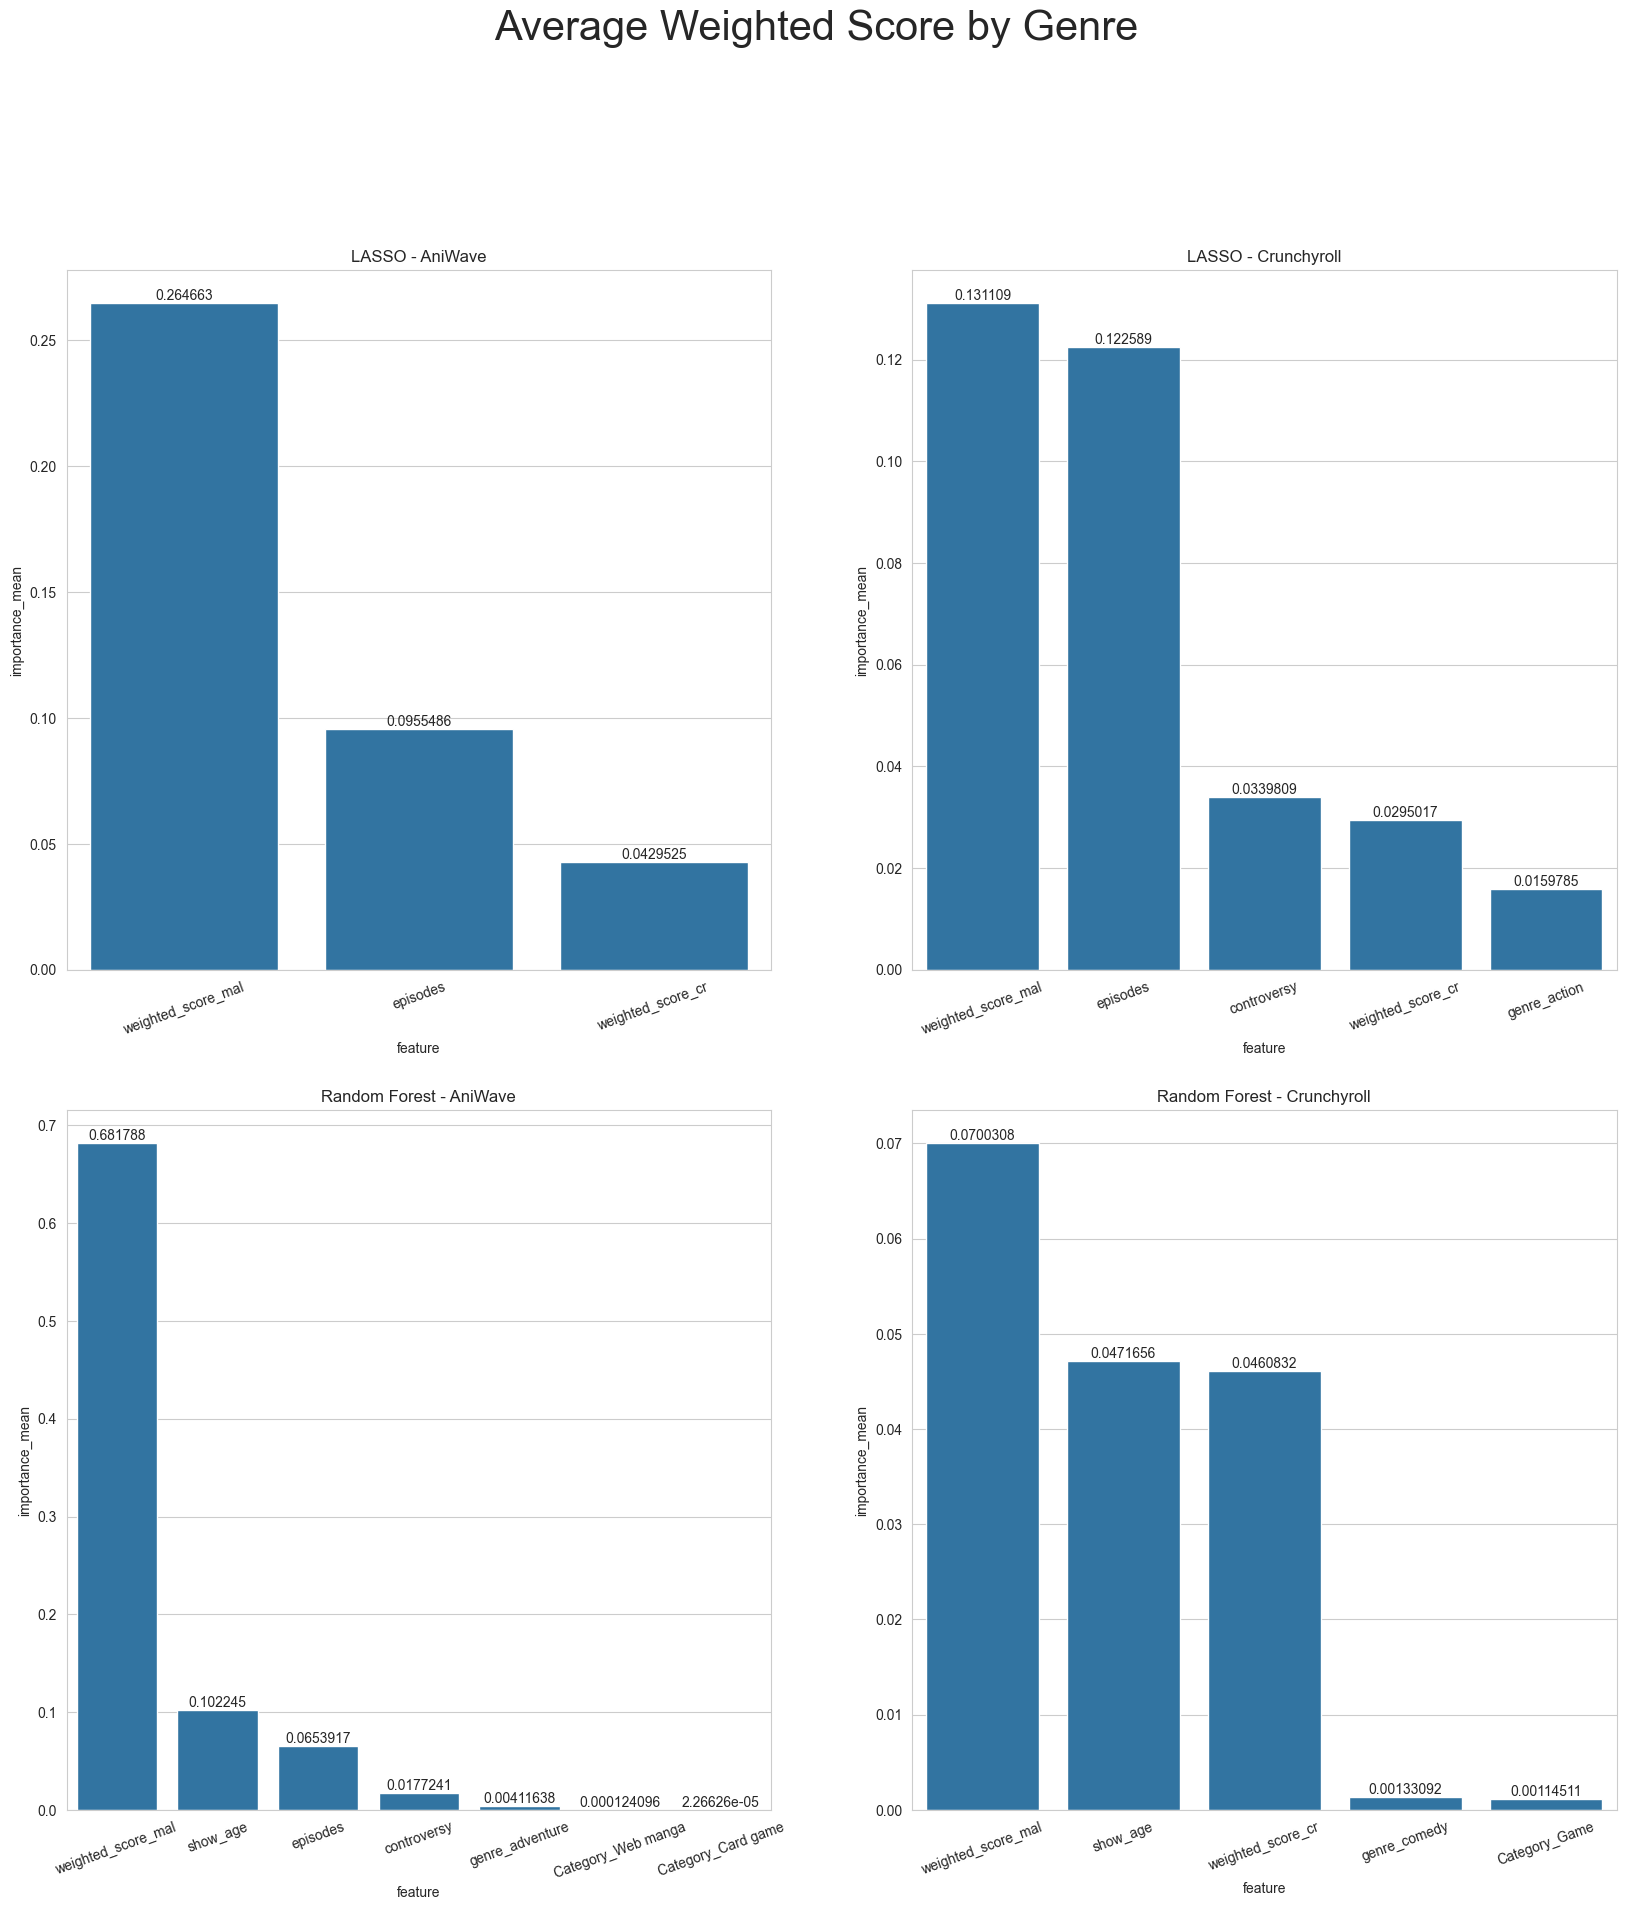

In [33]:
from sklearn.inspection import permutation_importance

models = [lasso_aw, lasso_cr, rf_aw, rf_cr]
models_str = ['LASSO - AniWave', 'LASSO - Crunchyroll', 'Random Forest - AniWave', 'Random Forest - Crunchyroll']
fig, axes = plt.subplots(2, 2, figsize=(20, 20))
#scoring = ['r2', 'neg_mean_absolute_percentage_error', 'neg_mean_squared_error']

for ax, model, model_str in zip(axes.flatten(), models, models_str): 
    print(model_str)
    X = X_cr_test
    y = y_cr_test
    if 'AniWave' in model_str:
        X = X_aw_test
        y = y_aw_test

    r = permutation_importance(model, X, y, n_repeats=30, random_state=5)
    
    barplot_data = pd.DataFrame(columns=['feature', 'importance_mean'])

    for i in r.importances_mean.argsort()[::-1]:
        # look only at the top 5 most important features
        if len(barplot_data) >= 10:
            continue
                
        # threshold for importance
        if r.importances_mean[i] - 2 * r.importances_std[i] > 0: 
            temp = pd.DataFrame({'feature':[X_aw_train.columns.values[i]], 
                                'importance_mean':[r.importances_mean[i]]})
            barplot_data = pd.concat([barplot_data, temp], ignore_index=True)
                
            print(f"{X_aw_train.columns.values[i]:<8}"
                f" {r.importances_mean[i]:.3f}"
                f" +/- {r.importances_std[i]:.3f}")
            
    sns.barplot(barplot_data, x='feature', y='importance_mean', ax=ax)
    ax.bar_label(ax.containers[0], fontsize=10);
    ax.tick_params(axis='x', rotation=20) 
    ax.set_title(model_str)
    fig.suptitle('Average Weighted Score by Genre', fontsize=30, y=1.01)
    plt.subplots_adjust(hspace = 0.2)
    
    print('\n')


# Follow-Up Analysis

In [16]:
from sklearn.linear_model import LinearRegression

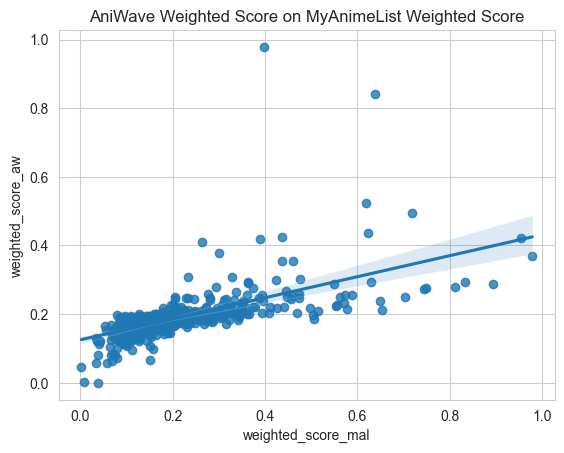

0.4036288904358303

In [17]:
X= acm[['weighted_score_mal']]
y= acm[['weighted_score_aw']]
sns.regplot(x=X, y=y)
plt.title('AniWave Weighted Score on MyAnimeList Weighted Score')
plt.show()


reg = LinearRegression().fit(X, y)
reg.score(X,y)

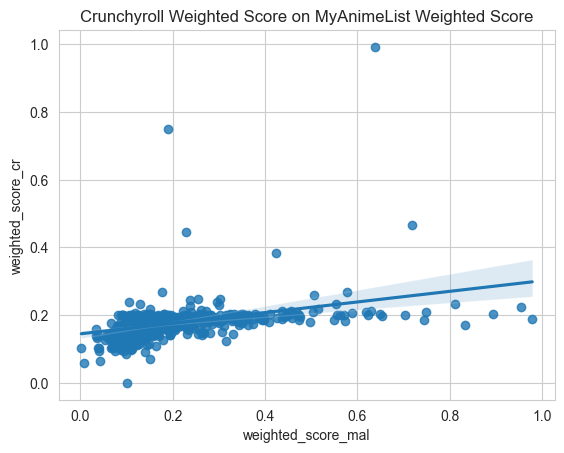

0.15293620677017772

In [18]:
X= acm[['weighted_score_mal']]
y= acm[['weighted_score_cr']]
sns.regplot(x=X, y=y)
plt.title('Crunchyroll Weighted Score on MyAnimeList Weighted Score')
plt.show()

reg = LinearRegression().fit(X, y)
reg.score(X,y)